# EG25 CITE-seq and flow cytometry comparisons

In this notebook 2-component Gaussian mixture model (GMM) is used to separate background signal from true signal. For some of the Easigenomics samples, blast phenotype data from flow cytometry is available, here this flow data is compared to CITE-seq results. Model is applied for both CLR and DSB normalized protein counts. 

Only one sample (all cells selected) is used to train the model.

### Sample information:
- ALL
- diagnosis
- 93% of bone marrow cells are blasts

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
from ridgeplot import ridgeplot

import sklearn.mixture

import warnings

warnings.filterwarnings('ignore')

## Preparing files

In [73]:
#raw protein data, all datasets, raw + CLR and DSB normalized

adata = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_easi_norm.h5ad')

adata.shape

(121340, 8051)

In [74]:
#select sample
adata_sample=adata[adata.obs['eg_code'] == 'EG25']

In [75]:
#all cells, CLR normalized proteins

prot_clr=adata_sample.obsm['protein_expression_clr']

prot_clr.shape

(3192, 33)

In [76]:
#all cells, CLR normalized proteins

prot_dsb=adata_sample.obsm['protein_expression_dsb']

prot_dsb.shape

(3192, 33)

In [77]:
#convert excel to csv (flow data)

read_file = pd.read_excel (r'/Users/tiinatuononen/Desktop/Thesis/Project/data/flow.xlsx')
read_file.to_csv (r'/Users/tiinatuononen/Desktop/Thesis/Project/data/flow.csv', index = None, header=True)

In [78]:
#get flow data

flow= pd.read_csv('/Users/tiinatuononen/Desktop/Thesis/Project/data/flow.csv')

### Depending on used dataset, celltype annotations are varying (made by different groups). "new_cell_types" is made based on these, it is a "standardized" version of cell type annotations. 

In [79]:
#Cell types offered by new_cell_type

adata.obs['new_cell_type'].unique().tolist()

['NK',
 'non-leukemic',
 'preleukemic',
 'non-leukemic?',
 nan,
 'leukemic',
 'leukemic?',
 'doublets?',
 'unknown',
 '0',
 'preleukemic?']

In [80]:
#cell type annotations offered by cell_type

adata.obs['cell_type'].unique().tolist()

['NKT',
 'non-leukemic',
 'preleukemic',
 'non-leukemic?',
 nan,
 'leukemic',
 'leukemic?',
 'doublets?',
 'unknown',
 '0',
 'preleukemic?']

## CLR normalized



In [81]:
#flow results for selected sample

egflow=flow[flow['EG_code'] == 'EG25'].dropna(axis=1)

egflow

,EG_code,CD19,CD22,CD24,CD58,CD81,HLA-DR
4,EG25,1.0,0.96,0.58,1.0,1.0,1.0


In [82]:
#drop EG_code

egflow=egflow.drop("EG_code", axis=1)

egflow

,CD19,CD22,CD24,CD58,CD81,HLA-DR
4,1.0,0.96,0.58,1.0,1.0,1.0


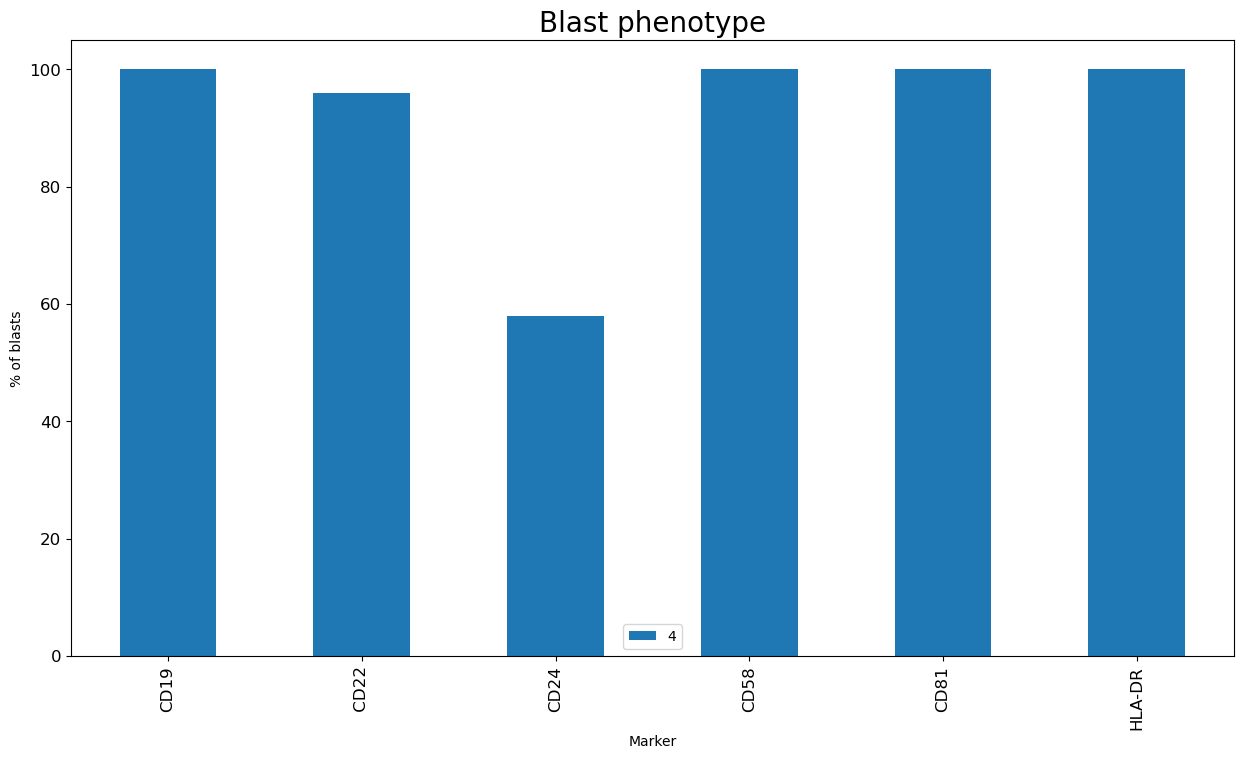

In [83]:
df=egflow * 100 #multiplied by 100 to get percentages

df1=df.T

df1.plot.bar(xlabel="Marker", ylabel="% of blasts",
            figsize= (15,8),
           fontsize="large") ;

plt.title('Blast phenotype', fontsize=20) ;

In [84]:
egflow=egflow*100

In [85]:
flow_markers=egflow.columns
flow_markers

Index(['CD19', ' CD22', 'CD24', 'CD58', 'CD81', 'HLA-DR'], dtype='object')

In [86]:
#Selecting common markers between flow and cite-seq

listOfMarkers=flow_markers
column_names=list()    #list including the common markers

for x in listOfMarkers:
    if x in prot_clr.columns:
        print(x, "Yes")
        column_names.append(x)
    else:
        print(x, "No") 
        
print(column_names)

CD19 Yes
 CD22 No
CD24 Yes
CD58 Yes
CD81 Yes
HLA-DR No
['CD19', 'CD24', 'CD58', 'CD81']


In [87]:
prot_clr.shape

(3192, 33)

In [88]:
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

Silhuette score: 0.4345206454362653
Percentage of positive cells, based on GMM: 74.56140350877193


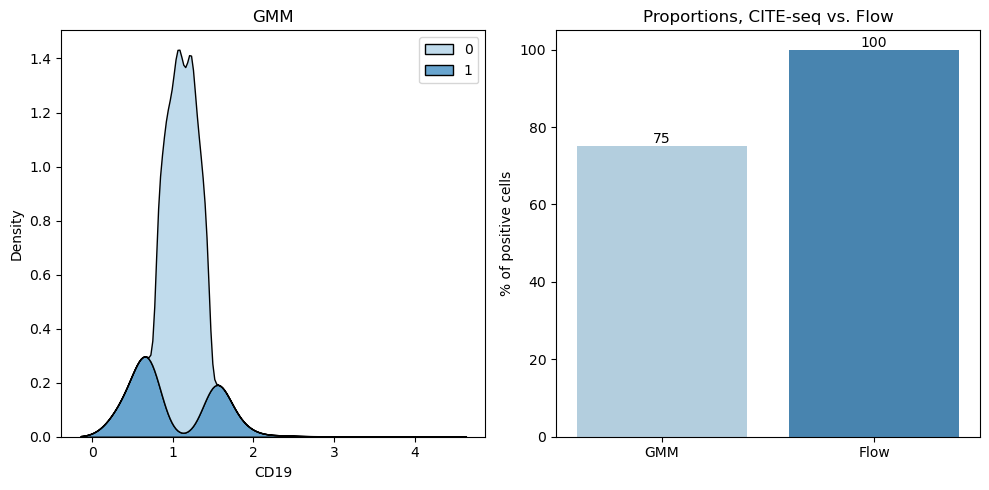

Silhuette score: 0.5591587195576632
Percentage of positive cells, based on GMM: 28.195488721804512


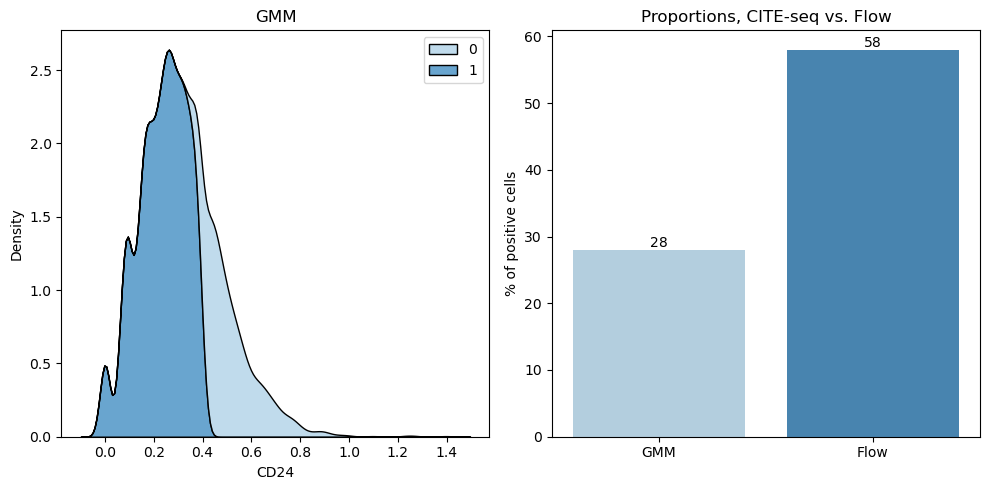

Silhuette score: 0.5353085929792413
Percentage of positive cells, based on GMM: 15.476190476190476


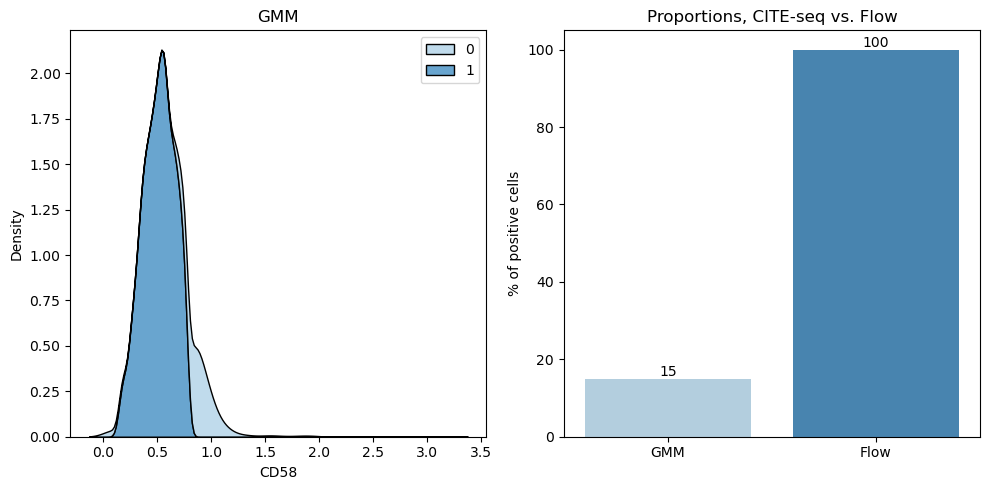

Silhuette score: 0.5204130068658956
Percentage of positive cells, based on GMM: 18.984962406015036


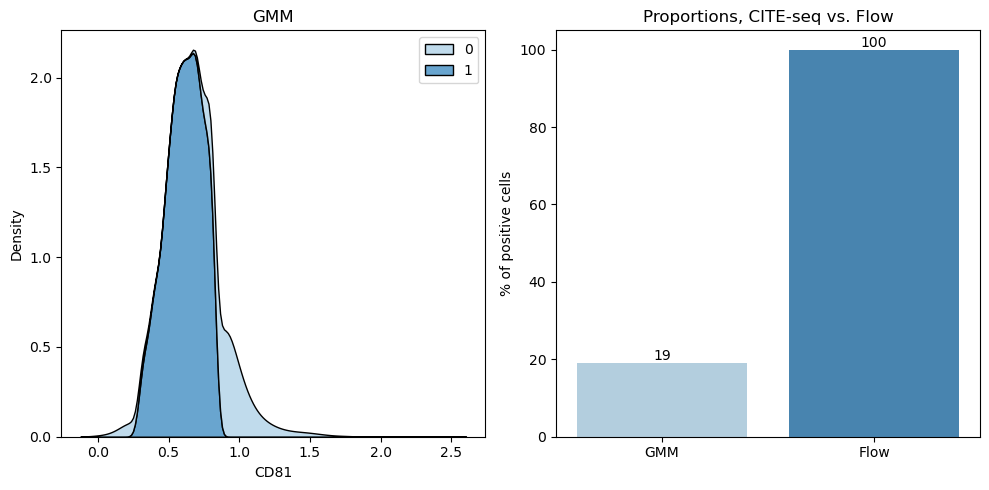

In [89]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "diag",
                                      random_state = 42
                                        )
#data
data=prot_clr
n_cells=len(prot_clr)
egflow=egflow
silhuette_scores_clr_diag = []

for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x= data[column_name]
    x=x.values.reshape(-1, 1)
    gmm.fit(x)
    labels = gmm.predict(x)
    score = silhouette_score(x, labels)
    print("Silhuette score:", score)
    silhuette_scores_clr_diag.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels == 1].mean()
    if x0 < x1:
        labels = (~(labels == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data, x=column_name, hue=labels, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels==0)
    result_zeros=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels)
    result_ones=(n_ones/n_cells * 100)
    #Dataframes
    all_data = {"GMM":[round(result_zeros)],
        "Flow": egflow[column_name],
        };

    all_data= pd.DataFrame(data=all_data);
    
    ax2=sns.barplot(data = all_data, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    plt.ylabel("% of positive cells", fontsize=10);
    for container in ax2.containers:
        ax2.bar_label(container)
    
    print("Percentage of positive cells, based on GMM:", result_zeros)
    
    plt.show()

Silhuette score: 0.4345206454362653
Percentage of positive cells, based on GMM: 74.56140350877193


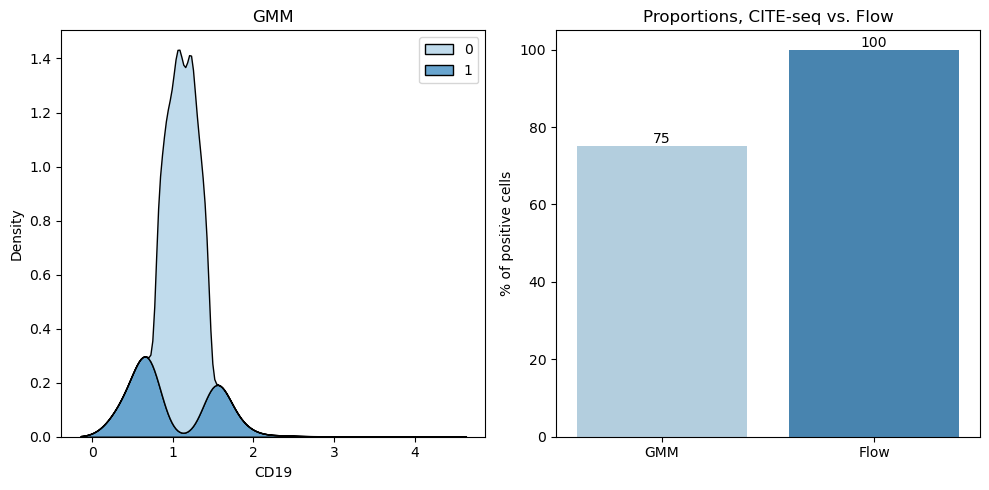

Silhuette score: 0.5591587195576632
Percentage of positive cells, based on GMM: 28.195488721804512


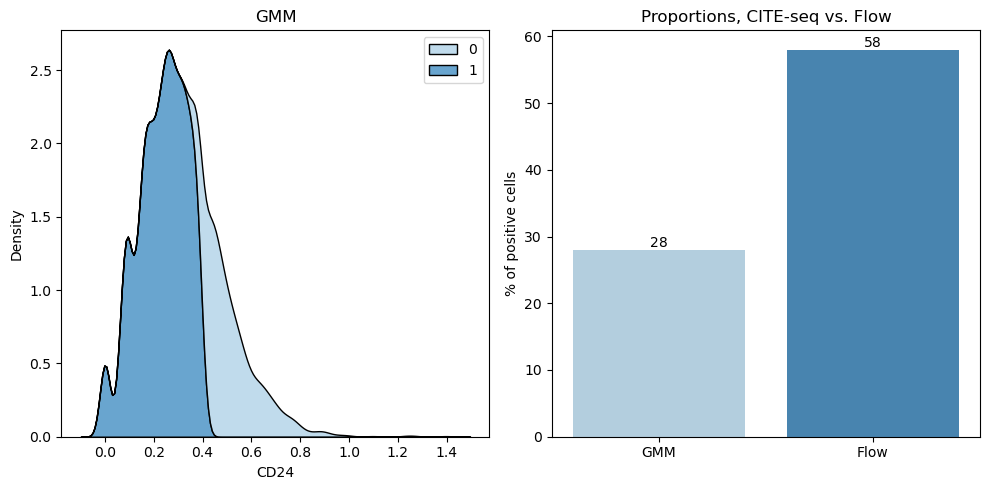

Silhuette score: 0.5353085929792413
Percentage of positive cells, based on GMM: 15.476190476190476


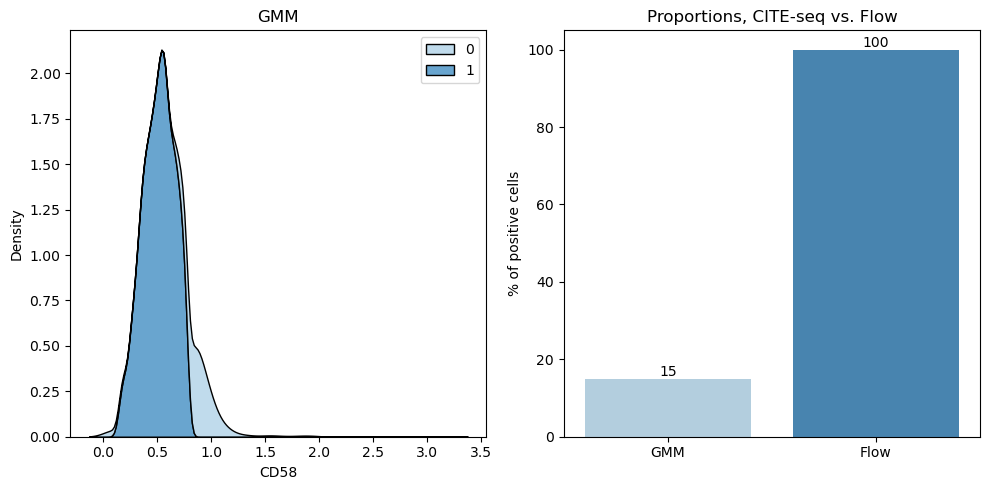

Silhuette score: 0.5204130068658956
Percentage of positive cells, based on GMM: 18.984962406015036


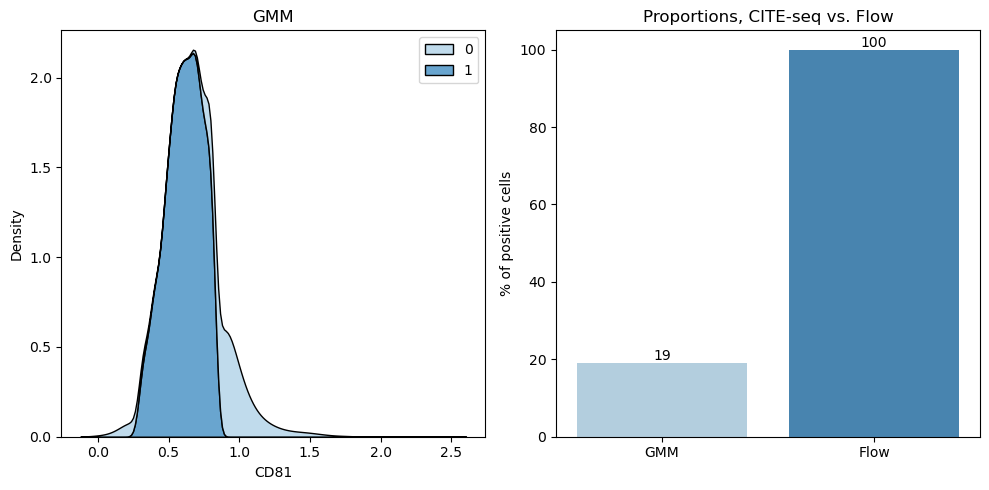

In [90]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "spherical",
                                      random_state = 42
                                        )
#data
data=prot_clr
n_cells=len(prot_clr)
egflow=egflow
silhuette_scores_clr_spher = []

for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x= data[column_name]
    x=x.values.reshape(-1, 1)
    gmm.fit(x)
    labels = gmm.predict(x)
    score = silhouette_score(x, labels)
    print("Silhuette score:", score)
    silhuette_scores_clr_spher.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels == 1].mean()
    if x0 < x1:
        labels = (~(labels == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data, x=column_name, hue=labels, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels==0)
    result_zeros=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels)
    result_ones=(n_ones/n_cells * 100)
    #Dataframes
    all_data = {"GMM":[round(result_zeros)],
        "Flow": egflow[column_name],
        };

    all_data= pd.DataFrame(data=all_data);
    
    ax2=sns.barplot(data = all_data, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    plt.ylabel("% of positive cells", fontsize=10);
    for container in ax2.containers:
        ax2.bar_label(container)
    
    print("Percentage of positive cells, based on GMM:", result_zeros)
    
    plt.show()

Silhuette score: 0.5299273143647681
Percentage of positive cells, based on GMM: 67.26190476190477


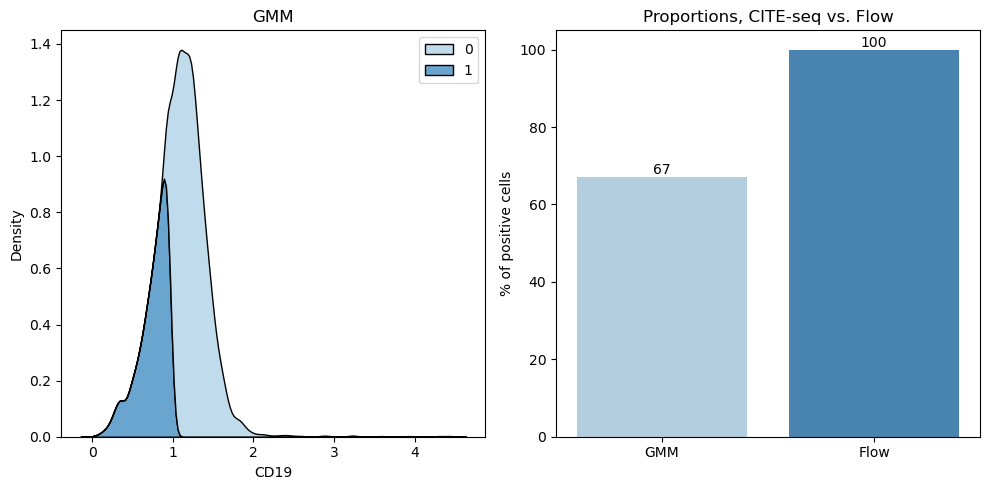

Silhuette score: 0.5488726531835673
Percentage of positive cells, based on GMM: 15.037593984962406


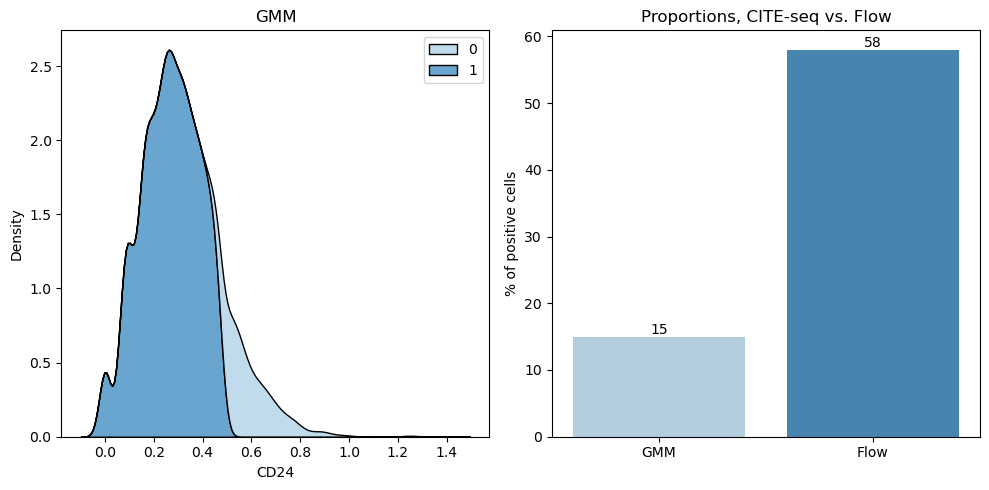

Silhuette score: 0.5487671957105509
Percentage of positive cells, based on GMM: 8.834586466165414


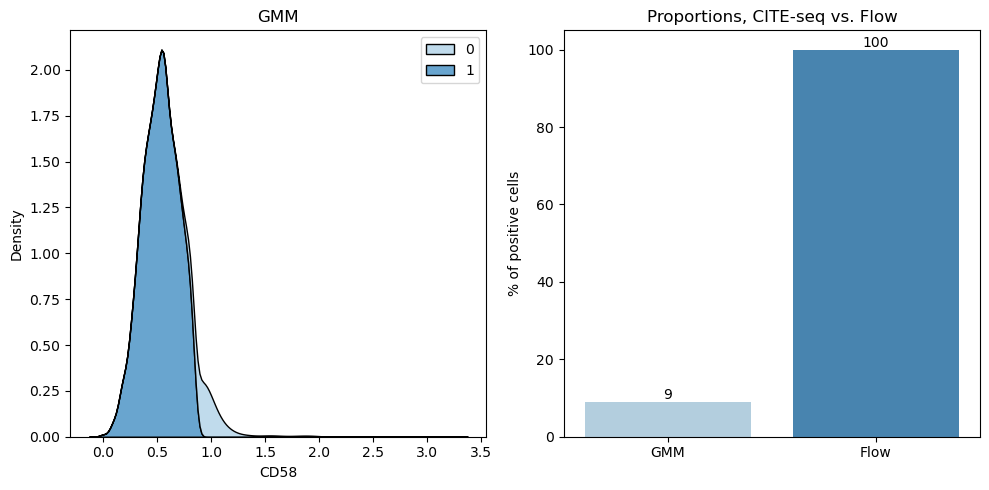

Silhuette score: 0.5316711504327323
Percentage of positive cells, based on GMM: 17.167919799498748


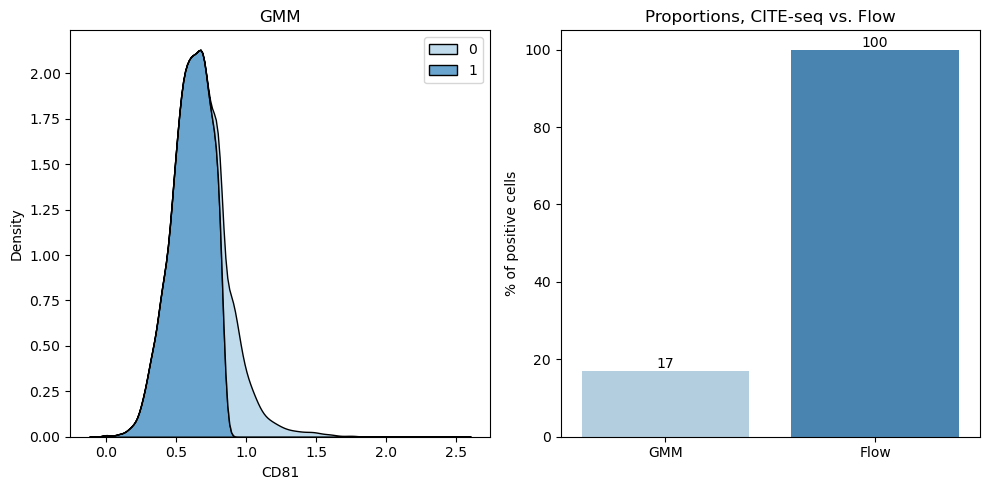

In [91]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "tied",
                                      random_state = 42
                                        )
#data

data=prot_clr
n_cells=len(prot_clr)
egflow=egflow
silhuette_scores_clr_tied = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x= data[column_name]
    x=x.values.reshape(-1, 1)
    gmm.fit(x)
    labels = gmm.predict(x)
    score = silhouette_score(x, labels)
    print("Silhuette score:", score)
    silhuette_scores_clr_tied.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels == 1].mean()
    if x0 < x1:
        labels = (~(labels == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data, x=column_name, hue=labels, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels==0)
    result_zeros=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels)
    result_ones=(n_ones/n_cells * 100)
    #Dataframes
    all_data = {"GMM":[round(result_zeros)],
        "Flow": egflow[column_name],
        };

    all_data= pd.DataFrame(data=all_data);
    
    ax2=sns.barplot(data = all_data, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    plt.ylabel("% of positive cells", fontsize=10);
    for container in ax2.containers:
        ax2.bar_label(container)
    
    print("Percentage of positive cells, based on GMM:", result_zeros)
    
    plt.show()

Silhuette score: 0.4345206454362653
Percentage of positive cells, based on GMM: 74.56140350877193


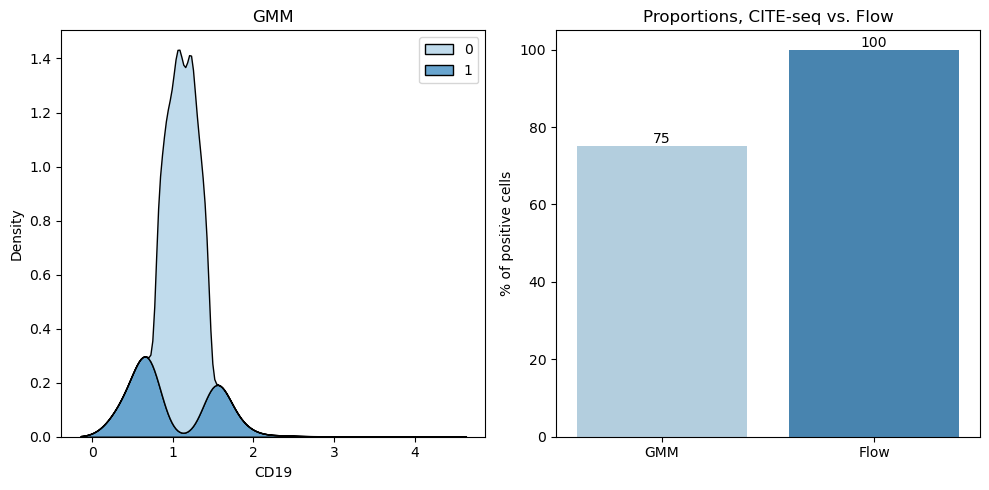

Silhuette score: 0.5591587195576632
Percentage of positive cells, based on GMM: 28.195488721804512


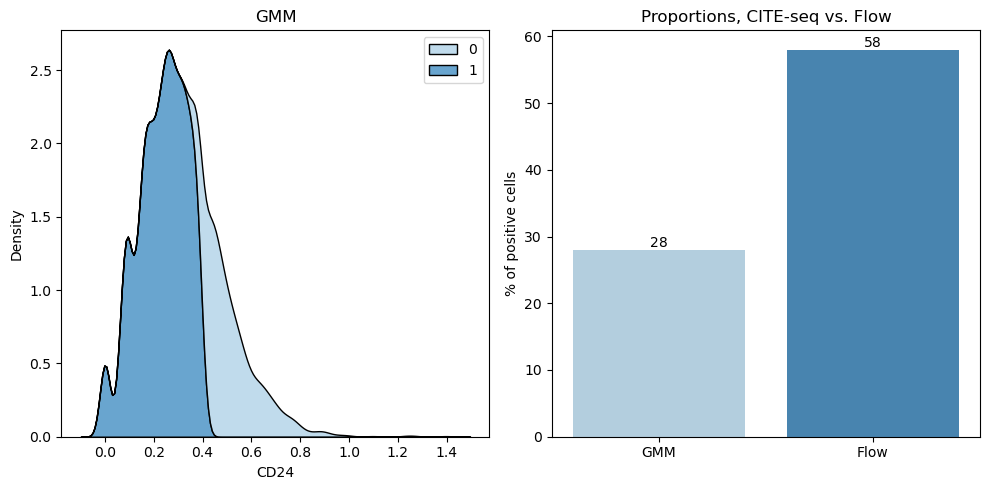

Silhuette score: 0.5353085929792413
Percentage of positive cells, based on GMM: 15.476190476190476


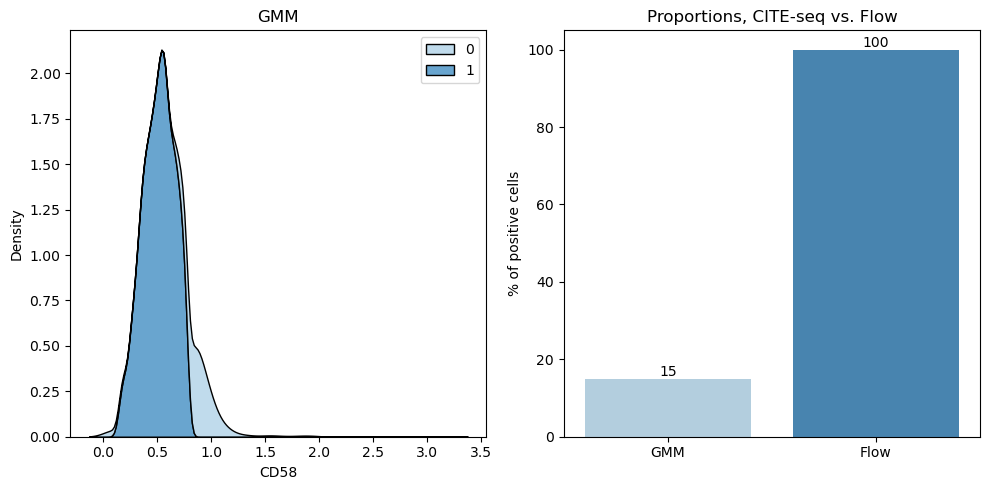

Silhuette score: 0.5204130068658956
Percentage of positive cells, based on GMM: 18.984962406015036


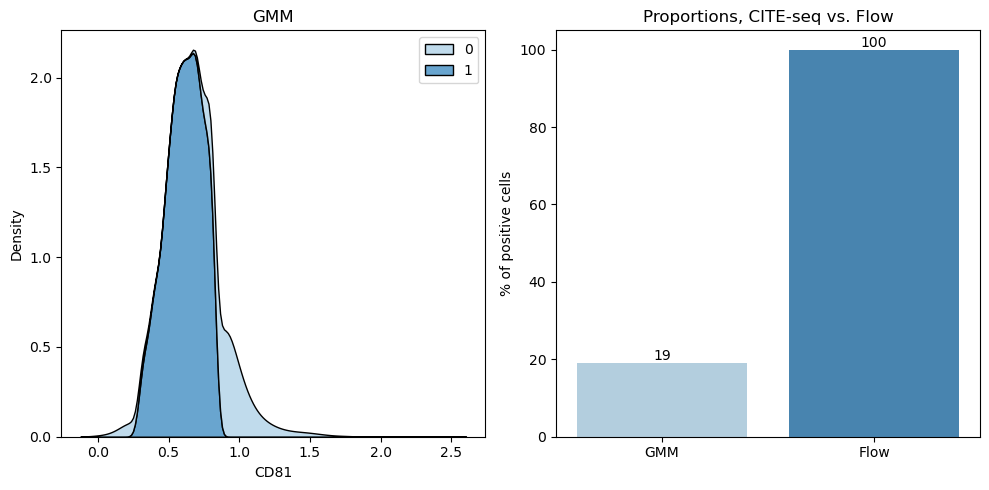

In [92]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "full",
                                      random_state = 42
                                        )
#data

data=prot_clr
n_cells=len(prot_clr)
egflow=egflow
silhuette_scores_clr_full = []

for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x= data[column_name]
    x=x.values.reshape(-1, 1)
    gmm.fit(x)
    labels = gmm.predict(x)
    score = silhouette_score(x, labels)
    print("Silhuette score:", score)
    silhuette_scores_clr_full.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels == 1].mean()
    if x0 < x1:
        labels = (~(labels == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data, x=column_name, hue=labels, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels==0)
    result_zeros=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels)
    result_ones=(n_ones/n_cells * 100)
    #Dataframes
    all_data = {"GMM":[round(result_zeros)],
        "Flow": egflow[column_name],
        };

    all_data= pd.DataFrame(data=all_data);
    
    ax2=sns.barplot(data = all_data, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    plt.ylabel("% of positive cells", fontsize=10);
    for container in ax2.containers:
        ax2.bar_label(container)
    
    print("Percentage of positive cells, based on GMM:", result_zeros)
    
    plt.show()

## DSB Normalized

In [93]:
prot_dsb

,CD19,CD10,CD20,CD3,CD2,CD11b,HLADR,CD38,CD11c,CD7,...,CD5,CD15,CD64,CD117,CD24,CD44,CD58,CD66ace,CD13,CD34
AAACCTGCATCTGGTA-1-158,1.233499,10.490325,0.298399,0.481133,0.447542,2.209640,10.253304,3.167907,1.722448,2.455797,...,0.891578,1.301091,0.046385,0.448538,-0.182913,4.108888,-0.730510,0.174821,-1.242754,8.957834
AAACCTGGTATGAAAC-1-158,3.047345,13.421921,0.298399,-0.124804,1.439466,1.098438,10.084808,7.173814,0.597070,1.329014,...,-0.012207,-1.804461,-0.560621,2.406809,2.581179,6.888614,1.705478,1.484647,-0.329018,11.624531
AAACCTGGTCGAACAG-1-158,0.657536,6.412783,-0.169555,-0.370382,-0.316384,-1.636618,2.570349,-0.601559,-1.286844,-0.705994,...,-1.055551,0.540348,0.852458,-1.356567,-1.629780,5.610284,-0.730510,-2.095107,-1.242754,6.712157
AAACCTGGTCTAGTCA-1-158,-0.900803,0.566633,-0.169555,-0.011552,15.307249,0.662341,0.898143,3.662848,0.994076,17.662724,...,-1.055551,0.261152,-0.344923,0.046999,1.040396,8.863292,1.019674,-0.865119,-0.329018,0.816546
AAACCTGGTCTGCGGT-1-158,1.839929,9.431325,-1.144322,-0.124804,-0.316384,1.302459,11.125561,3.167907,1.368383,-0.705994,...,-1.055551,-1.025544,-1.612562,0.448538,-0.182913,8.797567,2.114627,2.910192,1.272525,10.792358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTACATCCA-1-158,1.489006,10.929936,0.576136,-0.124804,0.796405,1.867083,4.496425,7.488725,-0.277374,2.455797,...,-0.012207,-0.674252,-0.143150,1.509651,6.819550,3.174085,1.019674,2.581041,3.263157,5.819686
TTTGTCAGTAGGCATG-1-158,1.098276,9.608678,-0.005828,0.808834,2.552255,0.662341,3.698918,6.153918,0.597070,0.028237,...,-0.012207,0.805919,-0.344923,-0.850160,-0.873417,4.802882,1.019674,3.224028,3.844364,7.402730
TTTGTCAGTATGCTTG-1-158,2.258353,11.252911,0.149908,-0.646733,0.796405,0.662341,4.190423,4.997655,-1.286844,1.329014,...,1.301905,1.059134,-0.143150,0.448538,0.452290,5.996411,-0.075279,0.174821,1.272525,8.440183
TTTGTCATCAAACCAC-1-158,2.158411,9.100399,0.576136,1.573386,1.439466,0.182565,9.610040,0.844980,-1.286844,1.911199,...,0.454759,-0.033143,0.225084,0.046999,2.100074,3.917282,0.222203,2.235003,1.272525,7.237783


In [94]:
#Selecting common markers between flow and cite-seq

listOfMarkers=flow_markers
column_names=list()    #list including the common markers

for x in listOfMarkers:
    if x in prot_dsb.columns:
        print(x, "Yes")
        column_names.append(x)
    else:
        print(x, "No") 
        
print(column_names)

CD19 Yes
 CD22 No
CD24 Yes
CD58 Yes
CD81 Yes
HLA-DR No
['CD19', 'CD24', 'CD58', 'CD81']


Silhuette score: 0.3707618
Percentage of positive cells: 67.76315789473685


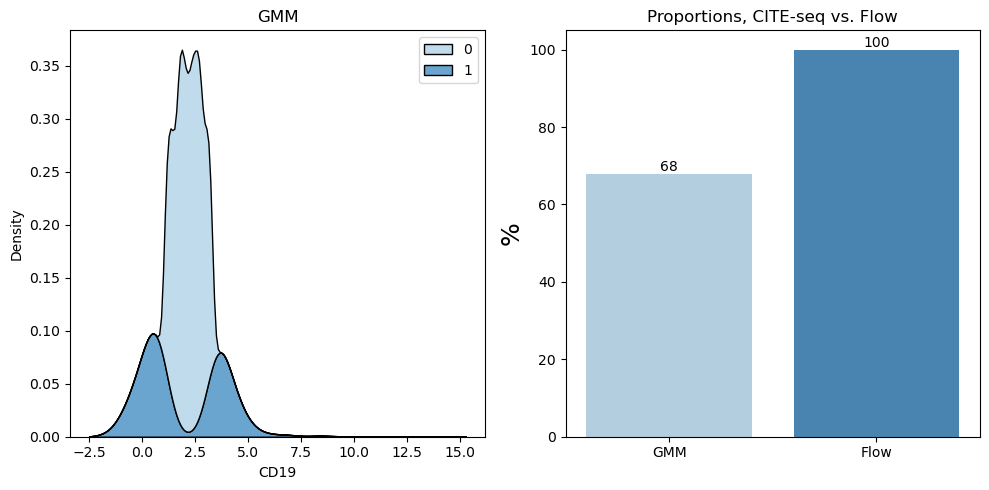

Silhuette score: 0.57253563
Percentage of positive cells: 22.932330827067666


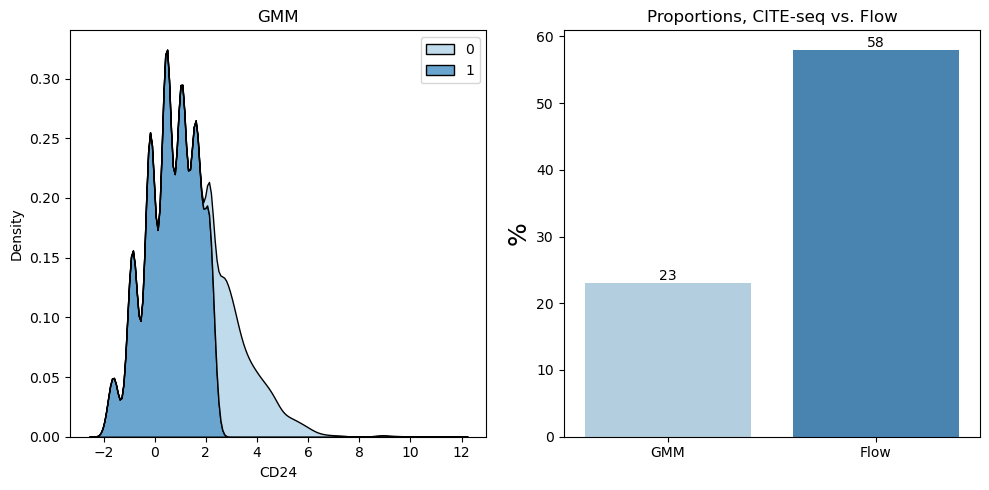

Silhuette score: 0.54969597
Percentage of positive cells: 23.590225563909776


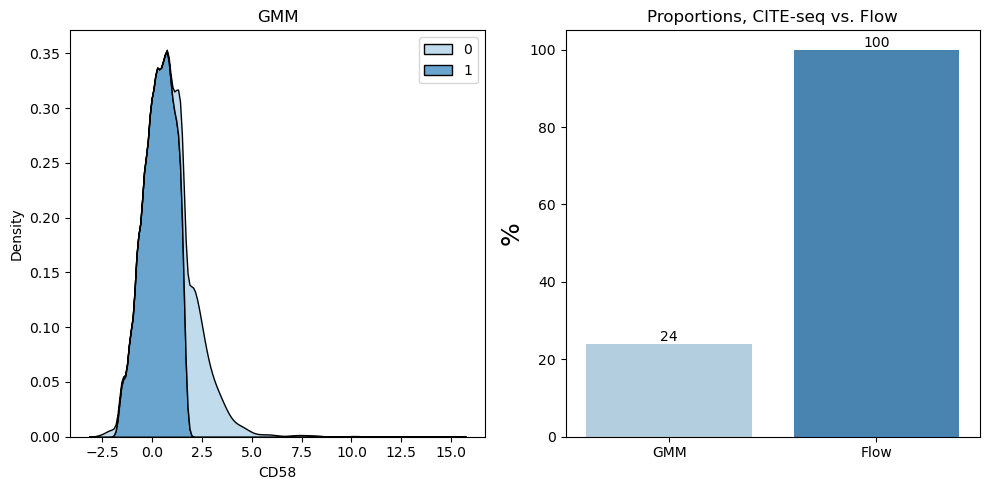

Silhuette score: 0.525423
Percentage of positive cells: 28.07017543859649


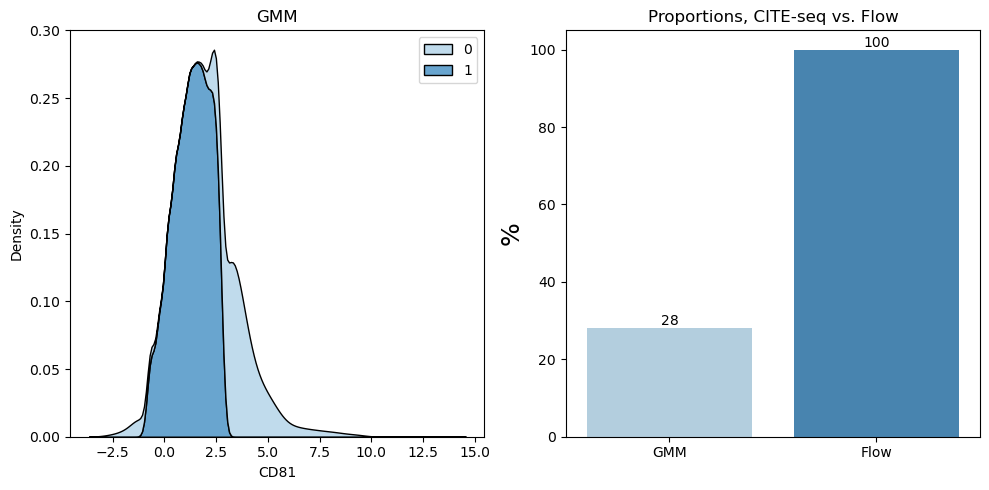

In [95]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "full",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow 
silhuette_scores_dsb_full = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x2= data_dsb[column_name]
    x2=x2.values.reshape(-1, 1)
    gmm.fit(x2)
    labels2 = gmm.predict(x2)
    score = silhouette_score(x2, labels2)
    print("Silhuette score:", score)
    silhuette_scores_dsb_full.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels2 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels2 == 1].mean()
    if x0 < x1:
        labels2 = (~(labels2 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels2, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels2==0)
    result_zeros2=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels2)
    result_ones2=(n_ones/n_cells * 100)
    #Dataframes
    all_data2 = {"GMM":[round(result_zeros2)],
        "Flow": egflow[column_name],
        };

    all_data2= pd.DataFrame(data=all_data2);
    
    ax2=sns.barplot(data = all_data2, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    for container in ax2.containers:
        ax2.bar_label(container)
    plt.ylabel("%", fontsize=18);
    
    print("Percentage of positive cells:", result_zeros2)
    
    plt.show()
    

Silhuette score: 0.3707618
Percentage of positive cells: 67.76315789473685


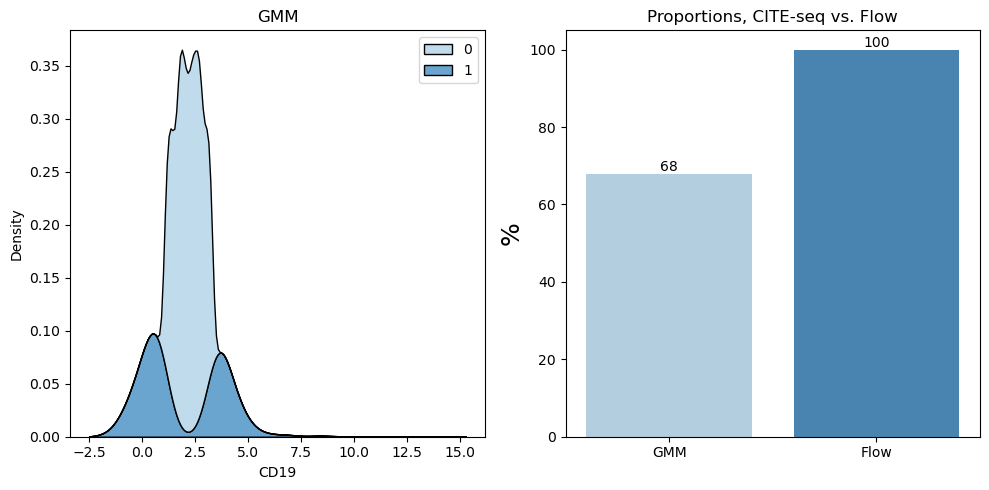

Silhuette score: 0.57253563
Percentage of positive cells: 22.932330827067666


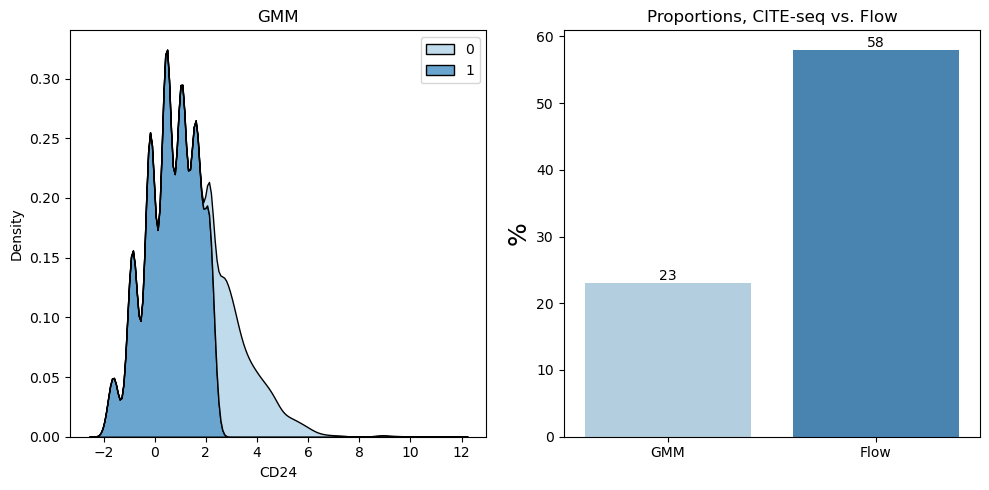

Silhuette score: 0.54969597
Percentage of positive cells: 23.590225563909776


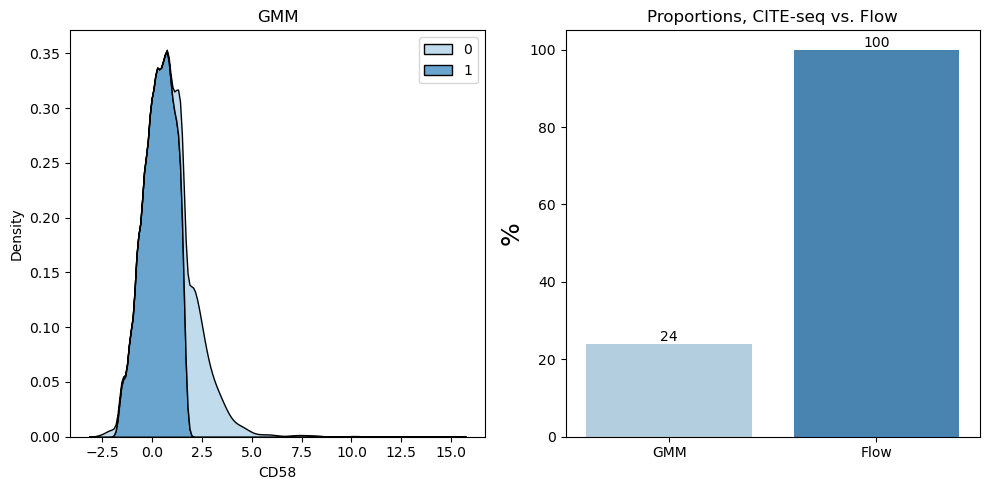

Silhuette score: 0.525423
Percentage of positive cells: 28.07017543859649


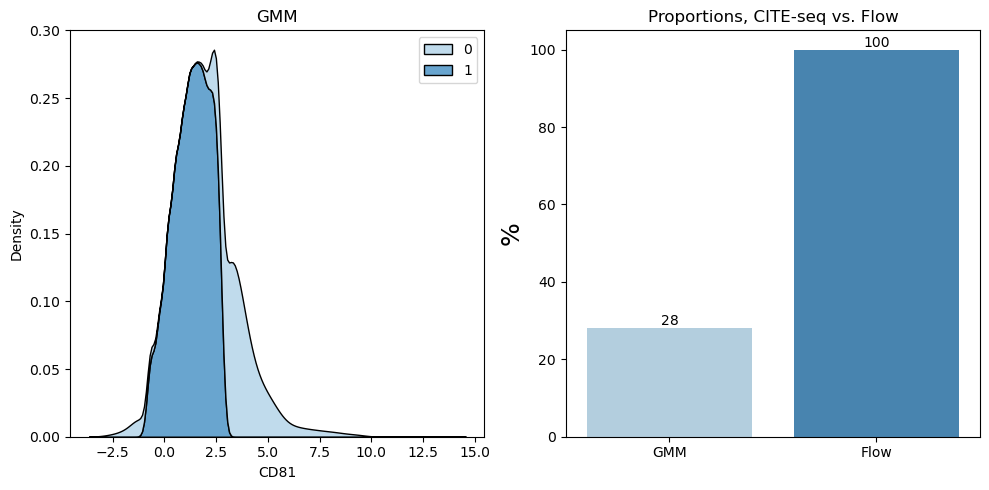

In [96]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "spherical",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow 
silhuette_scores_dsb_spher = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x2= data_dsb[column_name]
    x2=x2.values.reshape(-1, 1)
    gmm.fit(x2)
    labels2 = gmm.predict(x2)
    score = silhouette_score(x2, labels2)
    print("Silhuette score:", score)
    silhuette_scores_dsb_spher.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels2 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels2 == 1].mean()
    if x0 < x1:
        labels2 = (~(labels2 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels2, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels2==0)
    result_zeros2=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels2)
    result_ones2=(n_ones/n_cells * 100)
    #Dataframes
    all_data2 = {"GMM":[round(result_zeros2)],
        "Flow": egflow[column_name],
        };

    all_data2= pd.DataFrame(data=all_data2);
    
    ax2=sns.barplot(data = all_data2, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    for container in ax2.containers:
        ax2.bar_label(container)
    plt.ylabel("%", fontsize=18);
    
    print("Percentage of positive cells:", result_zeros2)
    
    plt.show()
    

Silhuette score: 0.53398126
Percentage of positive cells: 66.54135338345864


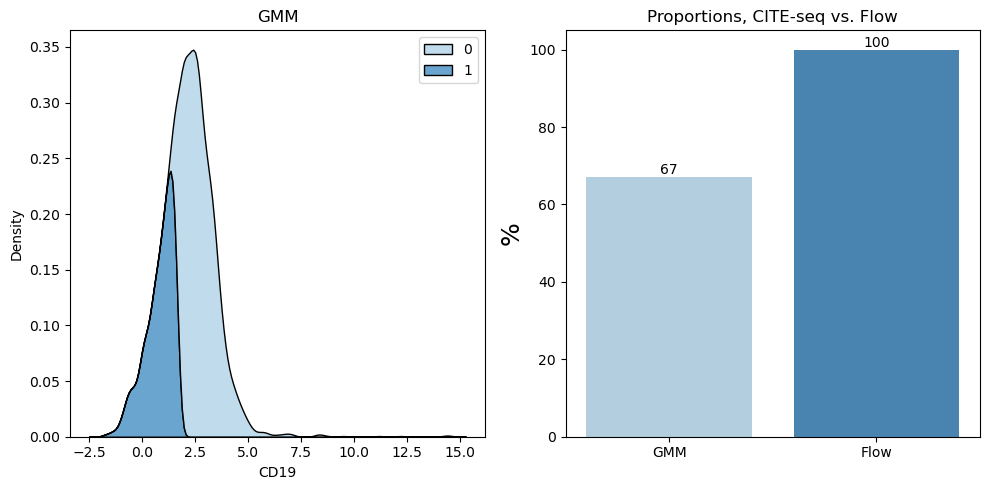

Silhuette score: 0.5588432
Percentage of positive cells: 15.695488721804512


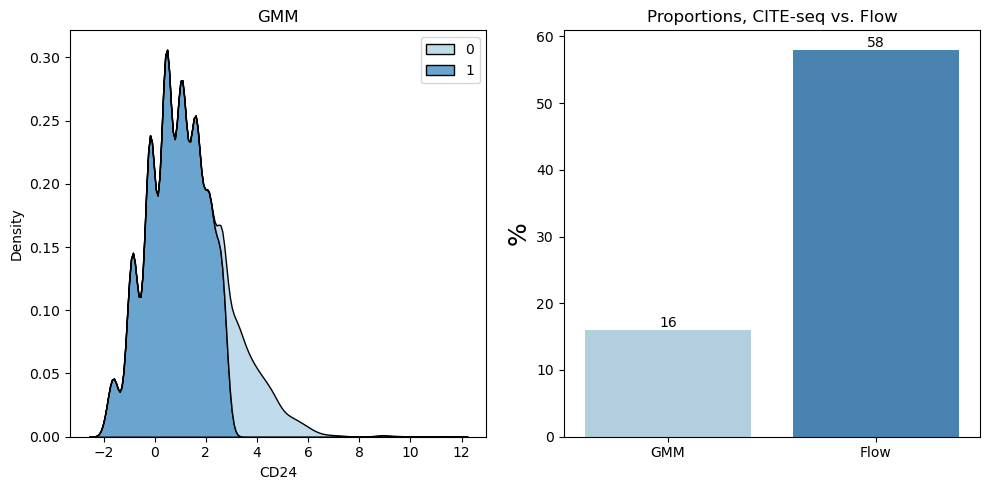

Silhuette score: 0.5657549
Percentage of positive cells: 11.99874686716792


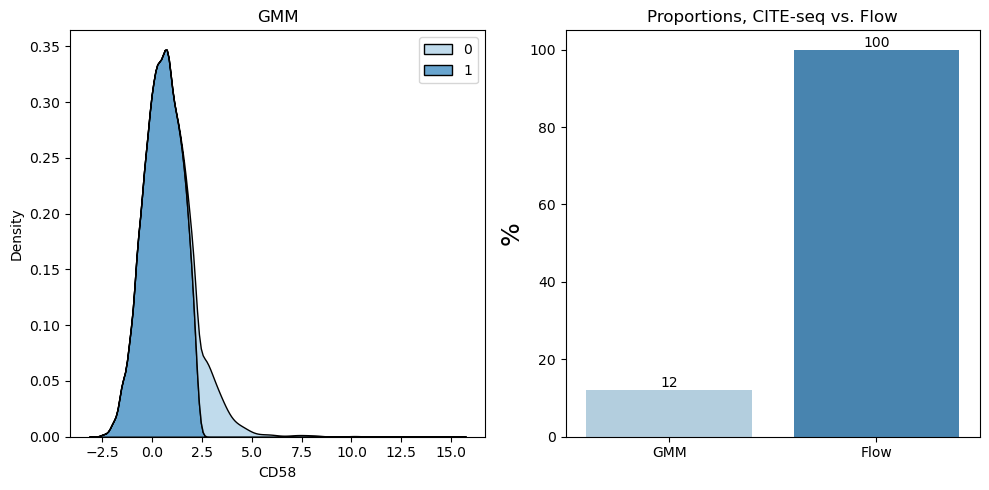

Silhuette score: 0.54548985
Percentage of positive cells: 17.293233082706767


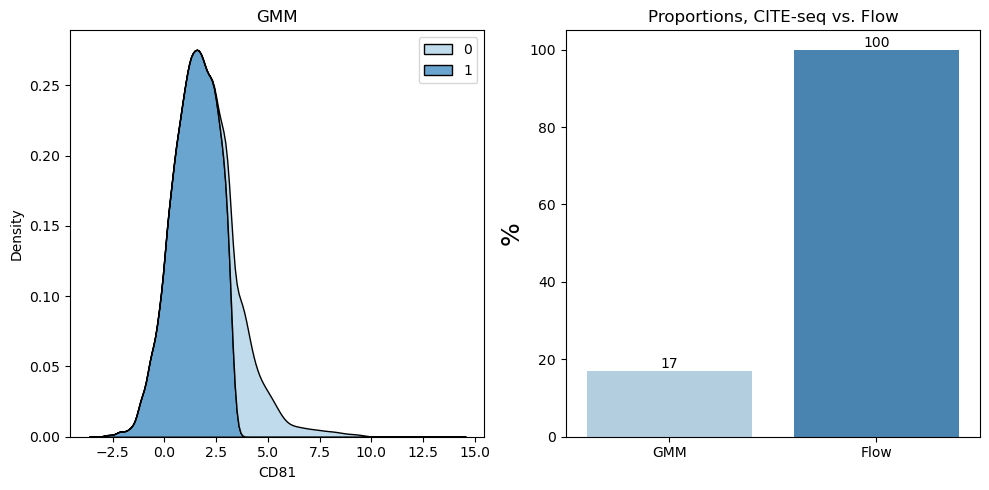

In [97]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "tied",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow 
silhuette_scores_dsb_tied = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x2= data_dsb[column_name]
    x2=x2.values.reshape(-1, 1)
    gmm.fit(x2)
    labels2 = gmm.predict(x2)
    score = silhouette_score(x2, labels2)
    print("Silhuette score:", score)
    silhuette_scores_dsb_tied.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels2 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels2 == 1].mean()
    if x0 < x1:
        labels2 = (~(labels2 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels2, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels2==0)
    result_zeros2=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels2)
    result_ones2=(n_ones/n_cells * 100)
    #Dataframes
    all_data2 = {"GMM":[round(result_zeros2)],
        "Flow": egflow[column_name],
        };

    all_data2= pd.DataFrame(data=all_data2);
    
    ax2=sns.barplot(data = all_data2, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    for container in ax2.containers:
        ax2.bar_label(container)
    plt.ylabel("%", fontsize=18);
    
    print("Percentage of positive cells:", result_zeros2)
    
    plt.show()
    

Silhuette score: 0.3707618
Percentage of positive cells: 67.76315789473685


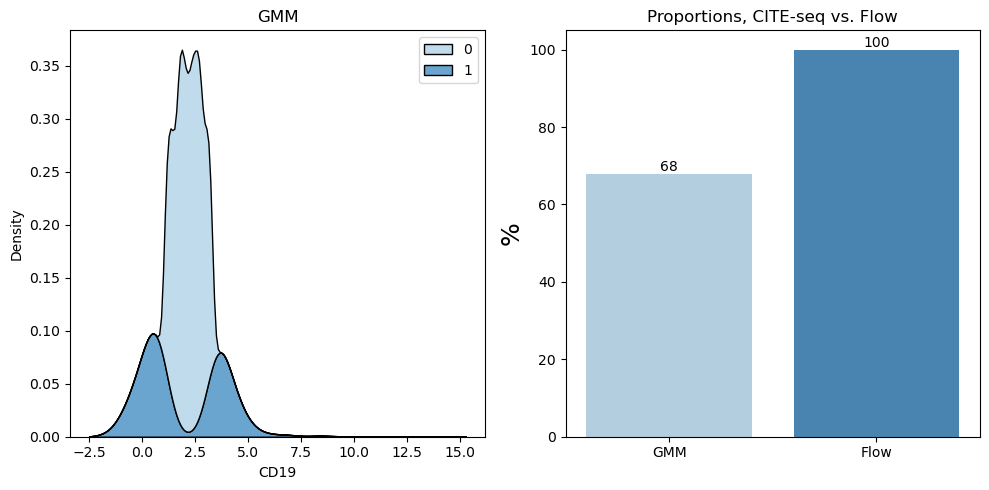

Silhuette score: 0.57253563
Percentage of positive cells: 22.932330827067666


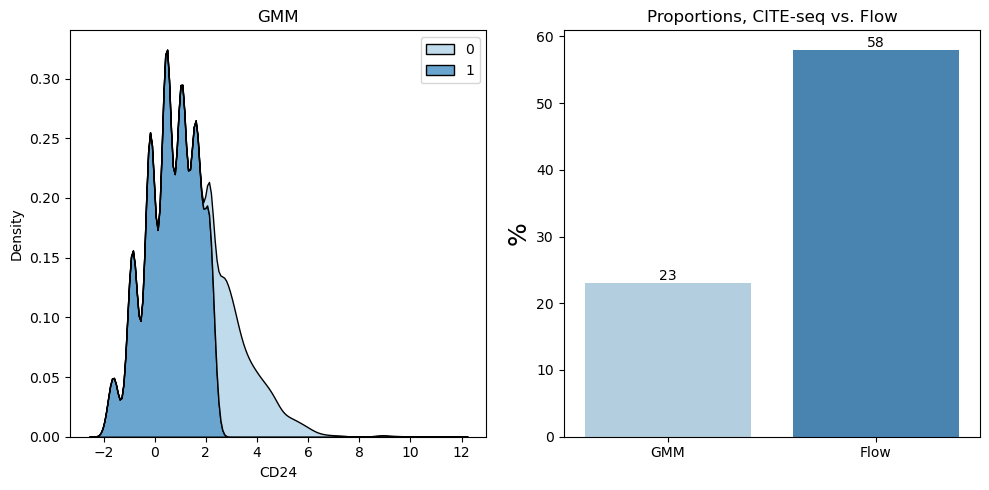

Silhuette score: 0.54969597
Percentage of positive cells: 23.590225563909776


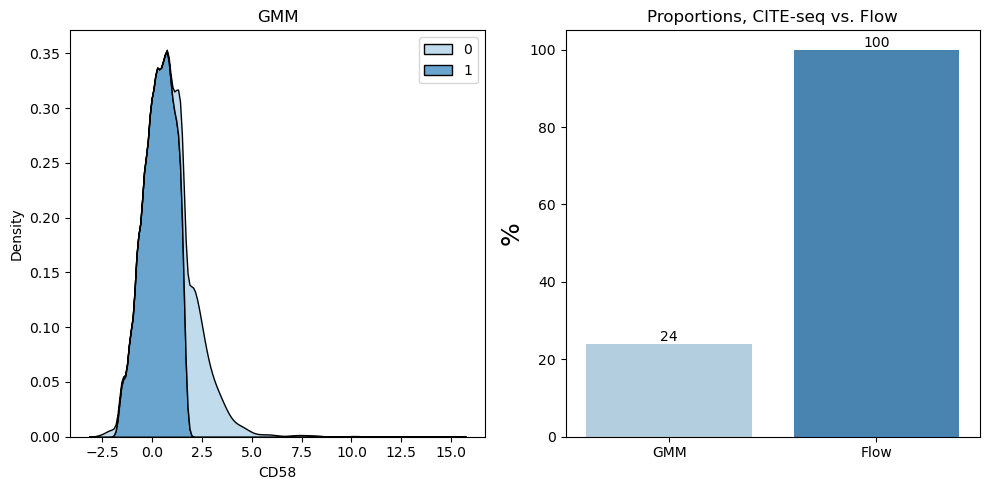

Silhuette score: 0.525423
Percentage of positive cells: 28.07017543859649


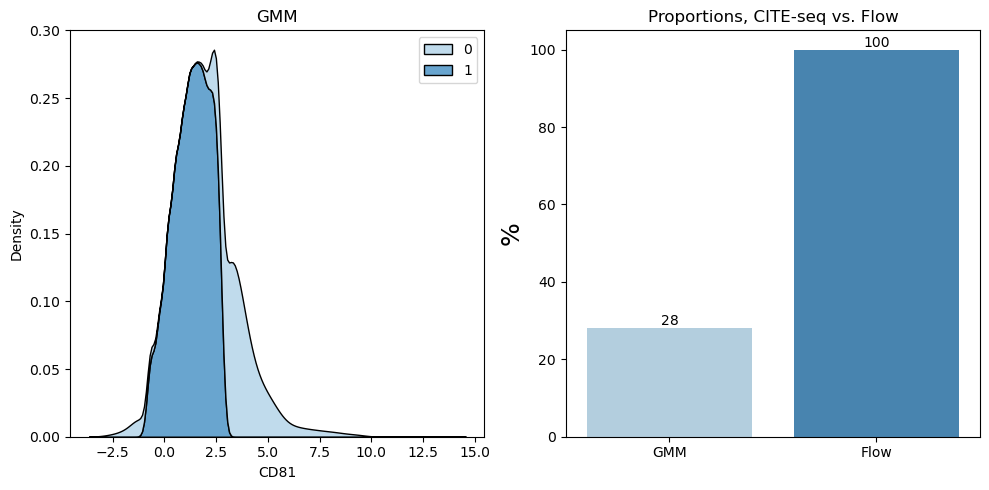

In [98]:
#model
gmm = sklearn.mixture.GaussianMixture(n_components = 2,
                                      covariance_type = "diag",
                                      random_state = 42
                                        )
#data

data_dsb=prot_dsb
n_cells=len(prot_dsb)
egflow=egflow 
silhuette_scores_dsb_diag = []


for column_name in column_names:
    fig, ax =plt.subplots(1,2,tight_layout=True, figsize=(10, 5))
    fig.show()
    
    x2= data_dsb[column_name]
    x2=x2.values.reshape(-1, 1)
    gmm.fit(x2)
    labels2 = gmm.predict(x2)
    score = silhouette_score(x2, labels2)
    print("Silhuette score:", score)
    silhuette_scores_dsb_diag.append(score)
    
    x0 = data[column_name].reset_index(drop=True)[labels2 == 0].mean()
    x1 = data[column_name].reset_index(drop=True)[labels2 == 1].mean()
    if x0 < x1:
        labels2 = (~(labels2 == 1)).astype(int)
    
    ax1 = sns.kdeplot(data=data_dsb, x=column_name, hue=labels2, palette="Blues", multiple="stack", ax=ax[0]) ;
    ax1.title.set_text('GMM')
       
    #Calculate zeros
    n_zeros = np.count_nonzero(labels2==0)
    result_zeros2=(n_zeros/n_cells * 100)
    #Calculate ones
    n_ones=np.count_nonzero(labels2)
    result_ones2=(n_ones/n_cells * 100)
    #Dataframes
    all_data2 = {"GMM":[round(result_zeros2)],
        "Flow": egflow[column_name],
        };

    all_data2= pd.DataFrame(data=all_data2);
    
    ax2=sns.barplot(data = all_data2, palette = "Blues", ax=ax[1]);
    ax2.title.set_text('Proportions, CITE-seq vs. Flow')
    for container in ax2.containers:
        ax2.bar_label(container)
    plt.ylabel("%", fontsize=18);
    
    print("Percentage of positive cells:", result_zeros2)
    
    plt.show()
    

## Silhuette scores

In [99]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[0]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[0]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[0]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[0]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[0]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[0]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[0]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[0]]
      };

silhuette_df= pd.DataFrame(data=silhuettes)

silhuette_df.T

,0
silhuette_scores_dsb_diag,0.370762
silhuette_scores_dsb_spher,0.370762
silhuette_scores_dsb_tied,0.533981
silhuette_scores_dsb_full,0.370762
silhuette_scores_clr_diag,0.434521
silhuette_scores_clr_spher,0.434521
silhuette_scores_clr_tied,0.529927
silhuette_scores_clr_full,0.434521


In [100]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[1]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[1]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[1]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[1]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[1]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[1]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[1]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[1]]
      };

silhuette_df1= pd.DataFrame(data=silhuettes)

silhuette_df1.T

,0
silhuette_scores_dsb_diag,0.572536
silhuette_scores_dsb_spher,0.572536
silhuette_scores_dsb_tied,0.558843
silhuette_scores_dsb_full,0.572536
silhuette_scores_clr_diag,0.559159
silhuette_scores_clr_spher,0.559159
silhuette_scores_clr_tied,0.548873
silhuette_scores_clr_full,0.559159


In [101]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[2]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[2]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[2]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[2]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[2]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[2]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[2]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[2]]
      };

silhuette_df2= pd.DataFrame(data=silhuettes)

silhuette_df2.T

,0
silhuette_scores_dsb_diag,0.549696
silhuette_scores_dsb_spher,0.549696
silhuette_scores_dsb_tied,0.565755
silhuette_scores_dsb_full,0.549696
silhuette_scores_clr_diag,0.535309
silhuette_scores_clr_spher,0.535309
silhuette_scores_clr_tied,0.548767
silhuette_scores_clr_full,0.535309


In [102]:
silhuettes = {"silhuette_scores_dsb_diag":[silhuette_scores_dsb_diag[3]],
              "silhuette_scores_dsb_spher": [silhuette_scores_dsb_spher[3]],
            "silhuette_scores_dsb_tied": [silhuette_scores_dsb_tied[3]],
              "silhuette_scores_dsb_full": [silhuette_scores_dsb_full[3]],
              "silhuette_scores_clr_diag":[silhuette_scores_clr_diag[3]],
              "silhuette_scores_clr_spher": [silhuette_scores_clr_spher[3]],
            "silhuette_scores_clr_tied": [silhuette_scores_clr_tied[3]],
              "silhuette_scores_clr_full": [silhuette_scores_clr_full[3]]
      };

silhuette_df3= pd.DataFrame(data=silhuettes)

silhuette_df3.T

,0
silhuette_scores_dsb_diag,0.525423
silhuette_scores_dsb_spher,0.525423
silhuette_scores_dsb_tied,0.545490
silhuette_scores_dsb_full,0.525423
silhuette_scores_clr_diag,0.520413
silhuette_scores_clr_spher,0.520413
silhuette_scores_clr_tied,0.531671
silhuette_scores_clr_full,0.520413


In [104]:
column_names


['CD19', 'CD24', 'CD58', 'CD81']

In [105]:
the_df= pd.concat([silhuette_df,silhuette_df1,silhuette_df2,silhuette_df3], axis=0)


In [106]:
the_df = the_df.T

the_df

,0,0,0,0
silhuette_scores_dsb_diag,0.370762,0.572536,0.549696,0.525423
silhuette_scores_dsb_spher,0.370762,0.572536,0.549696,0.525423
silhuette_scores_dsb_tied,0.533981,0.558843,0.565755,0.545490
silhuette_scores_dsb_full,0.370762,0.572536,0.549696,0.525423
silhuette_scores_clr_diag,0.434521,0.559159,0.535309,0.520413
silhuette_scores_clr_spher,0.434521,0.559159,0.535309,0.520413
silhuette_scores_clr_tied,0.529927,0.548873,0.548767,0.531671
silhuette_scores_clr_full,0.434521,0.559159,0.535309,0.520413


In [107]:
the_df.columns = column_names

In [112]:
the_df= the_df.T


In [113]:
the_df

,CD19,CD24,CD58,CD81
silhuette_scores_dsb_diag,0.370762,0.572536,0.549696,0.525423
silhuette_scores_dsb_spher,0.370762,0.572536,0.549696,0.525423
silhuette_scores_dsb_tied,0.533981,0.558843,0.565755,0.545490
silhuette_scores_dsb_full,0.370762,0.572536,0.549696,0.525423
silhuette_scores_clr_diag,0.434521,0.559159,0.535309,0.520413
silhuette_scores_clr_spher,0.434521,0.559159,0.535309,0.520413
silhuette_scores_clr_tied,0.529927,0.548873,0.548767,0.531671
silhuette_scores_clr_full,0.434521,0.559159,0.535309,0.520413


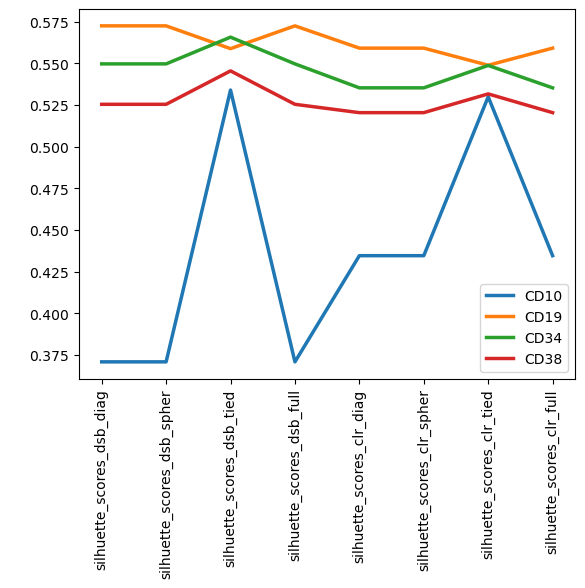

In [114]:
a = sns.lineplot(data=the_df["CD19"], palette=['red'], linewidth=2.5, label='CD10')
a = sns.lineplot(data=the_df["CD24"], palette=['green'], linewidth=2.5, label='CD19')
a = sns.lineplot(data=the_df["CD58"],palette=['black'],linewidth=2.5, label='CD34')
a = sns.lineplot(data=the_df["CD81"],palette=['blue'],linewidth=2.5, label='CD38')

a.set_xticklabels(a.get_xticklabels(),rotation=90) ;
plt.ylabel(" ");



- Silhuette scores are calculated for each protein, and compared between normalization mathods & different covariance types (diagonal, spherical, full)